# Práctica 2: Regresión Logística

### Jorge Villarrubia Elvira y Juan Carlos Villanueva Quirós

### Parte 1: Regresión logística
En esta primera parte aplicamos el método de regresión lineal sobre los datos del fichero ex1data1.csv que conienen notas de dos examenes de admisión de una universidad junto con la información de si fueron o no admitidos. Importamos todo lo necesario:

In [196]:
%matplotlib inline

import numpy as np
from numpy.linalg import inv
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opt
import matplotlib.cm as cm

Cargamos los datos del fichero, separan la clase a predecir de las variables

In [197]:
def carga_csv(file_name):
    """carga el fichero csv especificado y lo
    devuelve en un array de numpy
    """
    valores = read_csv(file_name, header=None).to_numpy()
    # suponemos que siempre trabajaremos con float
    return valores.astype(float)

def cargaXY_csv(file_name):
    valores = carga_csv(file_name)
    # Quitamos la última columna, que es la clase a predecir
    X = valores[:, :-1]
    #Tomamos la última columna como clase a predecir
    Y = valores[:, -1]
    return X, Y

X, Y = cargaXY_csv("ex2data1.csv")
m = np.shape(X)[0]

### Visualización de los datos
Visualizamos la distribución de puntos con distintos colores según su clase (admitido o no admitido). Parece que una recta, que va a ser nuestra hipótesis, puede separarlos bien.

In [198]:
def muestraPuntos(X, Y, col1 = 0, col2 = 1, xlabel = None, ylabel = None, legend = None):
    pos = np.where(Y == 1)
    plt.scatter(X[pos,col1], X[pos,col2], marker = '+', c = 'k')
    pos = np.where(Y == 0)
    plt.scatter(X[pos,col1], X[pos,col2], marker = '.', c = 'y')
    if xlabel != None:
        plt.xlabel(xlabel)
    if ylabel != None:
        plt.ylabel(ylabel)
    if legend != None:
        plt.legend(legend, loc = 'upper right')

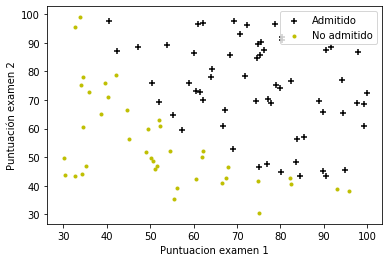

In [199]:
muestraPuntos(X,Y, xlabel = 'Puntuacion examen 1', ylabel ='Puntuación examen 2',
              legend = ['Admitido', 'No admitido'])

Añadimos una columna de unos a las variables para poder hacer los cálculos matricialmente en lugar de con un bucle.

In [200]:
X_conUnos = np.hstack([np.ones([m,1]), X])

### Función sigmoide, función de coste y su gradiente

Definimos las función sigmoide y las funciones de coste y gradiente de manera vectorial que serán usadas en el descenso de gradiente para tratar de buscar los coeficientes theta que minimizan la función de coste. 

In [201]:
def sigmoide(z):
    return 1/ (1 + np.exp(-z))

def coste(theta, X, Y):
    m = np.shape(X)[0]
    return (np.matmul(np.log(sigmoide(np.matmul(X, theta))).T, Y)\
    + np.matmul(np.log(1 - sigmoide(np.matmul(X, theta))).T, (1-Y)))/-m

def gradiente(theta, X, Y):
    m = np.shape(X)[0]
    return np.matmul(X.T, sigmoide(np.matmul(X,theta)) - Y)/m

Comprobamos que, tal y como advierte el enunciado, inicializando el vector $\theta$ a 0, el valor del coste es de proximadamente 0.693 y el de gradiente de [ -0.1 -12.0092 -11.2628]

In [202]:
print('Coste:', coste(X = X_conUnos,theta = np.array([0,0,0]), Y = Y))
print('Gradiente:', gradiente(X = X_conUnos,theta = np.array([0,0,0]), Y = Y))

Coste: 0.6931471805599452
Gradiente: [ -0.1        -12.00921659 -11.26284221]


### Cálculo del valor óptimo de los parámetros

Calculamos el valor óptimo de los pesos theta llamando a la función fmin_tnc de scipy.optimize con: la función a optimizar, los valores iniciales para los pesos $\theta_i$ (por ejemplo todos a 0), el nombre de la función del gradiente y la tupla con los argumentos extra ( en nuestro caso los datos de nuestro problema X_conUnos e Y).

Comprobamos que con los valores del theta óptimo el coste es de aproximadamente 0.203

In [203]:
theta = np.array([0,0,0])
result = opt.fmin_tnc(func = coste, x0 = theta, fprime = gradiente, args=(X_conUnos,Y))
theta_opt = result[0]
print('Coste con theta óptimo:', coste(theta_opt, X_conUnos, Y))

Coste con theta óptimo: 0.20349770158947497


Representamos los puntos junto a la recta dada por el $\theta$ óptimo. Apreciamos que la separación es la esperada y bastante correcta.

In [204]:
def pinta_frontera_recta(X, Y, theta):
    #plt.figure()
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
    np.linspace(x2_min, x2_max))

    h = sigmoide(np.c_[np.ones((xx1.ravel().shape[0], 1)),
    xx1.ravel(),
    xx2.ravel()].dot(theta))
    h = h.reshape(xx1.shape)

     # el cuarto parámetro es el valor de z cuya frontera se
     # quiere pintar
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
    #plt.show()
    #plt.close()

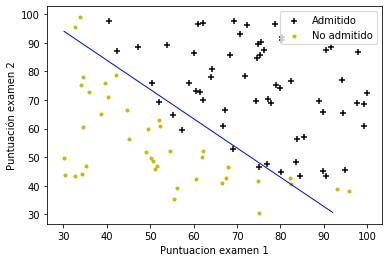

In [205]:
muestraPuntos(X,Y, xlabel = 'Puntuacion examen 1', ylabel ='Puntuación examen 2',
              legend = ['Admitido', 'No admitido'])
pinta_frontera_recta(X, Y, theta_opt)

### Evaluación de la regresión logística

Finalmente, para evaluar cómo de bien funciona el modelo, vamos a calcular el porcentaje de ejemplos de entrenamiento que se clasifian correctamente utilizando el vector theta óptimo. Si el sigmoide sobre devuelve un valor >= 0.5 sobre el valor en la recta de un ejemplo de entrenamiento está prediciendo la clase 1 (alumnos admitidos) y si no está prediciendo la clase 0 (alumnos no admitidos).

Basta comparar con las clases correctas para calcular el acuraccy o porcentaje de aciertos. No sale un accuracy bastante bueno, del 89%.

In [206]:
def porcentajeAciertos(X, theta, Y):
    y_predicted = sigmoide(np.matmul(X,theta)) >= 0.5
    return np.mean(y_predicted == Y) * 100

In [207]:
print('El porcentaje de aciertos es del:', porcentajeAciertos(X_conUnos, theta_opt, Y),'%')

El porcentaje de aciertos es del: 89.0 %


### Parte 2: Regresión logística regularizada

En esta parte vamos a utilizar regresión logística regularizada para encontrar una función que
pueda predecir si un microchip pasará o no el control de calidad. La regularización nos permitirá eludir el sobreaprendizaje. Comencemos por cargar y visualizar los datos.

In [208]:
X, Y = cargaXY_csv("ex2data2.csv")

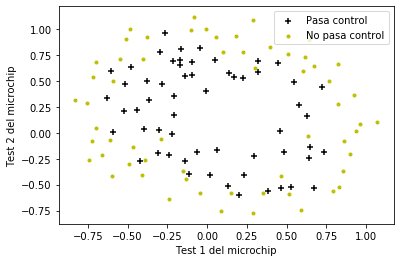

In [209]:
muestraPuntos(X, Y, xlabel = 'Test 1 del microchip', ylabel ='Test 2 del microchip',
              legend = ['Pasa control', 'No pasa control'])

En este caso parece que una recta es una mala hipótesis. Habrá que utilizar algo de grado superior.

### Mapeo de los atributos

Utilizamos la clase sklearn.preprocessing.PolynomialFeatures para extender
cada ejemplo de entrenamiento con los términos polinómicos de $x_1$ y $x_2$ hasta la sexta potencia,
completando así un total de 28 atributos para cada ejemplo

In [210]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X)

### Cálculo de la función de coste y su gradiente

Definimos la nueva función de coste regularizado, que depende del parámetro $\lambda$ y la nueva función con su gradiente. Son iguales que las anteriores, salvo por un sumando nuevo que constituye la regularización.

In [211]:
def costeRegu(theta, X, Y, lamda):
    m = np.shape(X)[0]
    return (np.matmul(np.log(sigmoide(np.matmul(X, theta))).T, Y)\
    + np.matmul(np.log(1 - sigmoide(np.matmul(X, theta))).T, (1-Y)))/-m\
    + lamda* np.sum(theta**2)/(2*m)
def gradienteRegu(theta, X, Y, lamda):
    m = np.shape(X)[0]
    aux = lamda/m * theta
    aux[0] = 0
    return np.matmul(X.T, sigmoide(np.matmul(X,theta)) - Y)/m + aux

Comprobamos que, como nos anuncia el enunciado, para $\lambda = 1$ y el vector de $\theta$ todo ceros, el coste regularizado es de aproximadamente 0.693

In [212]:
theta = np.zeros(np.shape(X_poly)[1])
print('Coste regularizado:', costeRegu(theta, X_poly, Y, 1))

Coste regularizado: 0.6931471805599453


### Cálculo del valor óptimo de los parámetros

De nuevo, llamamos a la función scipy.optimize.fmin_tnc para obtener el valor óptimo $\theta$ con la versión del coste y del gradiente regularizadas, y con los 28 valores correspondientes a los términos polinómicos de $x_1$ y $x_2$ hasta la potencia sexta. Lo hacemos con $\theta$ inicial todos ceros y valor de $\lambda = 1$.

Con ello, como era de esperar, el coste a baja desde 0.693 hasta 0.535 aproximadamente.

In [213]:
lamda = 1
theta = np.zeros(X_poly.shape[1])
result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_poly,Y, lamda))
theta_opt = result[0]

In [214]:
print('Coste con theta óptimo, para lambda = 1:', costeRegu(theta_opt, X_poly, Y, 1))

Coste con theta óptimo, para lambda = 1: 0.5357749512479768


Representamos la curva con contorno con la que se está clasificando. Vemos que separa bastante bien las dos clases y se asemeja a lo esperado.

In [215]:
def plot_decisionboundary(X, Y, theta, poly, color = 'g'):
    #plt.figure()
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
    np.linspace(x2_min, x2_max))
    h = sigmoide(poly.fit_transform(np.c_[xx1.ravel(),
    xx2.ravel()]).dot(theta))
    h = h.reshape(xx1.shape)
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors=color)
    #plt.savefig("boundary.pdf")
    #plt.show()
    #plt.close()

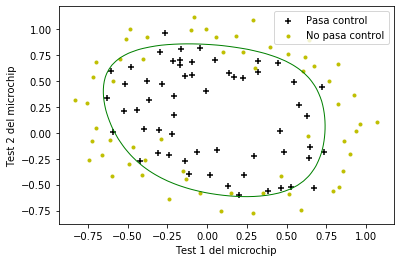

In [216]:
muestraPuntos(X, Y, xlabel = 'Test 1 del microchip', ylabel ='Test 2 del microchip',
              legend = ['Pasa control', 'No pasa control'])
plot_decisionboundary(X, Y, theta_opt, poly)

### Efectos de la regularización

Finalmente, movemos el valor del parámetro $\lambda$ en cierto rango viendo como afecta este término. Representamos el coste regularizado, el porcentaje de aciertos y los contornos con los que se trata de clasificar.

Vemos que con $\lambda = 0$, es decir, sin regularización, el coste es el menor posible y los aciertos sobre entrenamiento son máximos, pero se está sobreaprendiendo. La curva roja de la última gráfica muestra que, de forma muy abrupta, se consiguen separar mejor las clases mediante el contorno.

Al aumentar el parámetro se pierden accuracy y el coste de la función para el theta mínimo es mayor, pero la forma de la frontera que separ las clases es más suave, y seguramente más realista. No hay ese sobreaprendizaje y es una mejor opción de cara a predecir valores que no estén en el conjunto de entrenamiento. Se generaliza mejor.

In [217]:
def testLamda(rango):
    costes_lamda = []
    for lamda in rango:
        result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_poly,Y, lamda))
        theta_opt = result[0]
        costes_lamda.append(costeRegu(theta_opt, X_poly, Y, lamda))
    plt.plot(rango, costes_lamda)
    plt.xlabel('Valor de lambda')
    plt.ylabel('Coste')
    plt.title('Coste en función de lambda')
    plt.show()
    
    aciertos_lamda = []
    for lamda in rango:
        result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_poly,Y, lamda))
        theta_opt = result[0]
        aciertos_lamda.append(porcentajeAciertos(X_poly, theta_opt, Y))
    plt.plot(rango, aciertos_lamda)
    plt.xlabel('Valor de lambda')
    plt.ylabel('Porcentaje de aciertos (accuracy)')
    plt.title('Aciertos entrenamiento en función de lambda')
    plt.show()

    colors = colors = ['r', 'b', 'y', 'g', 'orange', 'm', 'yellow', 'indigo', 'coral', 'tan', 'aqua']
    for lamda, color in zip(rango, colors):
        result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_poly,Y, lamda))
        theta_opt = result[0]
        muestraPuntos(X, Y, xlabel = 'Test 1 del microchip', ylabel ='Test 2 del microchip',
                      legend = ['Pasa control', 'No pasa control'])
        plot_decisionboundary(X, Y, theta_opt, poly, color)
    plt.title('Fronteras de clasificacion')

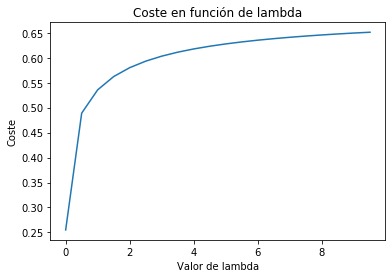

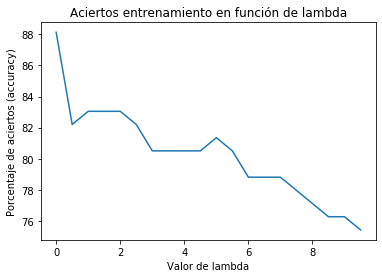

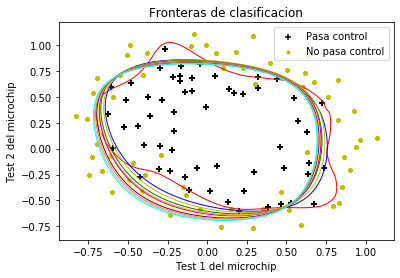

In [218]:
testLamda(np.arange(0,10,0.5))